In [1]:
import sys
lib = r'D:\Technion studies\Keren Laboratory\python_playground\classifying-response-to-immunotherapy\utilities\droplet_dataset'
lib2 = r'D:\Technion studies\Keren Laboratory\python_playground\classifying-response-to-immunotherapy\utilities'
lib3 = r'D:\Technion studies\Keren Laboratory\python_playground\classifying-response-to-immunotherapy\data_analysis'
lib4 = r'D:\Technion studies\Keren Laboratory\python_playground\classifying-response-to-immunotherapy'
sys.path.append(lib)
sys.path.append(lib2)
sys.path.append(lib3)
sys.path.append(lib4)

In [2]:
import os
from os.path import join
import sklearn
# from droplet_dataset import *
# from utilities import *
from matplotlib import pyplot
import numpy as np
import scipy
import pickle
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import random
from scipy.stats import pearsonr
from matplotlib.pyplot import figure
import time
import matplotlib.pyplot as plt
import copy
from sklearn.cluster import KMeans
from collections import Counter
from PIL import Image, ImageColor


* Functions

In [101]:
def draw(chro_genes_vals):
    n_gene = chro_genes_vals.shape[0]
    n_cells = chro_genes_vals.shape[1]
    
    deletions = copy.deepcopy(chro_genes_vals)
    deletions[deletions < -0.02] = 195
    insertions = copy.deepcopy(chro_genes_vals)
    insertions[insertions > 0.02] = 195


    rgbArray = np.zeros((n_gene, n_cells, 3), 'uint8')
    rgbArray[..., 0] = insertions #*256
    rgbArray[..., 1] = 0 #chro_genes_vals*256
    rgbArray[..., 2] = deletions #chro_genes_vals*256
    img = Image.fromarray(rgbArray)
    return img


def draw_split(_chro_genes_vals, split_idx):
    n_gene = _chro_genes_vals.shape[0]
    n_cells = _chro_genes_vals.shape[1]
    
    deletions = copy.deepcopy(_chro_genes_vals)
    deletions[deletions < -0.02] = 195
    insertions = copy.deepcopy(_chro_genes_vals)
    insertions[insertions > 0.02] = 195


    rgbArray = np.zeros((n_gene, n_cells + 3, 3), 'uint8')
    rgbArray[:, :split_idx+1, 0] = insertions[:, :split_idx+1]
    rgbArray[:, split_idx+4:, 0] = insertions[:, split_idx+1:]
    rgbArray[:, split_idx+1: split_idx+4, 1] = 200
    rgbArray[:, :split_idx+1, 2] = deletions[:, :split_idx+1]
    rgbArray[:, split_idx+4:, 2] = deletions[:, split_idx+1:]
    img = Image.fromarray(rgbArray)
    return img



def ones_conversion(chro_genes_vals):
    conv = copy.deepcopy(chro_genes_vals)
    conv[conv > 0.02] = 1
    conv[conv < -0.02] = -1
    conv[(conv < 1) & (conv > -1)] = 0
    return conv

def pos_conversion(chro_genes_vals):
    conv = copy.deepcopy(chro_genes_vals)
    conv[conv > 0.02] = 1
    conv[conv < 0.02] = 0
    return conv

def neg_conversion(chro_genes_vals):
    conv = copy.deepcopy(chro_genes_vals)
    conv[conv > -0.02] = 0
    conv[conv < -0.02] = 1
    return conv


def is_a_cnv_group(cluster):
    cluster = np.abs(ones_conversion(cluster))
    num_of_genes = cluster.shape[1]
    num_of_cells = cluster.shape[0]
#     print(f'gene len {num_of_genes}')
#     print(f'cells len {num_of_cells}')
    
    
#     print(cells_thrshold)
#     print(np.sum(cluster, axis=0).shape)
    cells_thrshold = int(num_of_cells*0.9)
    number_of_cnv_genes_overlap_with_90p_cells = sum(np.sum(cluster, axis=0)>cells_thrshold)
    print(f'Number of CNV genes (approved by > 90% of the cells): {number_of_cnv_genes_overlap_with_90p_cells}')
    
    cells_thrshold = int(num_of_cells*0.8)
    number_of_cnv_genes_overlap_with_80p_cells = sum(np.sum(cluster, axis=0)>cells_thrshold)
    print(f'Number of CNV genes (approved by > 80% of the cells): {number_of_cnv_genes_overlap_with_80p_cells}')

* Selsect the path of the onferCNV output you are interested in

In [8]:
SAMPLE = 'M133'


path = join(r'D:\Technion studies\Keren Laboratory\python_playground\outputs\inferCNV\executions\all_data_31.12.20', SAMPLE)
file = r'infercnv.observations.txt'
genome_path = r'D:\Technion studies\Keren Laboratory\Data\inferCNV_data\gencode_v19_gene_pos.txt'
print(f"FILE PATH:\n{join(path, file)}", end='\n\n')
print(f"SAMPLE: \n{SAMPLE}")

FILE PATH:
D:\Technion studies\Keren Laboratory\python_playground\outputs\inferCNV\executions\all_data_31.12.20\M133\infercnv.observations.txt

SAMPLE: 
M133


* Loading sample CNV map

In [11]:
print(f'LOADING FILE:\n{join(path, file)}', end ='\n\n')

count = 0
genes_vals =[]
gene_names = []
barcodes = None
s_time = time.time()
with open(join(path, file), 'r') as f:
    for line in f:
        if not count % 1000:
            current_time = time.time() - s_time
            print(f'line num: {count + 1} current time {round(current_time, 2)} sec')
        if count == 0:
            barcodes_length = len(line[:-1].split(' '))
            print(f'number of barcodes {barcodes_length}')
            barcodes = [ii.replace('\"', '') for ii in line.split(' ')]
        else:
            gene = [aa for aa in line[:-1].split(' ')]
            gene_names.append(gene[0].replace('\"', ''))
            genes_vals.append([float(val) for val in gene[1:]])
#         if count > 100:
#             break
        count +=1

genes_vals = np.array(genes_vals)
print(f'DONE', end='\n\n')


print(f'Number of genes {count}')
print(f'Number of barcodes {barcodes_length}')

LOADING FILE:
D:\Technion studies\Keren Laboratory\python_playground\outputs\inferCNV\executions\all_data_31.12.20\M133\infercnv.observations.txt
line num: 1 current time 0.0 sec
number of barcodes 5529
line num: 1001 current time 2.02 sec
line num: 2001 current time 4.03 sec
line num: 3001 current time 6.08 sec
line num: 4001 current time 8.15 sec
line num: 5001 current time 10.29 sec
line num: 6001 current time 12.49 sec
DONE

Number of genes 6613
Number of barcodes 5529


Loading genome file in order to map genes to chromosomes

In [14]:
print(f'Loading genome file')


genes_details = list()
with open(genome_path, 'r') as f:
    for line in f:
        genes_details.append(line[:-1].split('\t'))
genome_genes = [gg[0] for gg in genes_details]
gene_names_chr = [(gg, int(genes_details[genome_genes.index(gg)][1].replace('chr', ''))) for gg in gene_names]
chromosomes = list(set([gg[1] for gg in gene_names_chr]))
print(f'DONE')



def retrieve_genes_indices_by_chro(chro_num):
    return [idx for idx, gg in enumerate(gene_names_chr) if gg[1]==chro_num]


Loading genome file
DONE


* Select a chromosome which we analyse later.


Sample:                         M133
Chromosome 1 has been selected
Num of genes (in chromosome 1): 748
Num of cells:                   5529


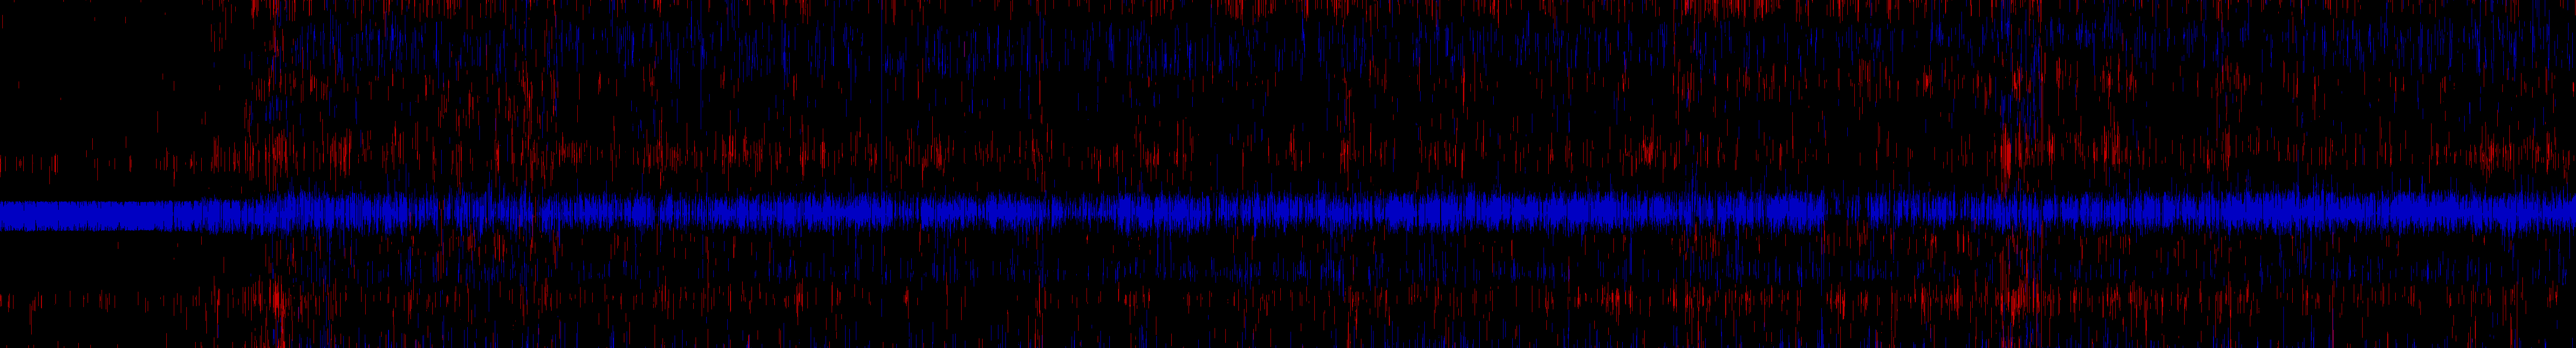

In [78]:
chro = 1

chro_indices = retrieve_genes_indices_by_chro(chro)
chro_genes_vals = genes_vals[chro_indices, :]#.sum(axis=0)
chro_genes_vals = (chro_genes_vals-1)

print(f'Sample:                         {SAMPLE}')
print(f'Chromosome {chro} has been selected')
print(f'Num of genes (in chromosome {chro}): {chro_genes_vals.shape[0]}')
print(f'Num of cells:                   {chro_genes_vals.shape[1]}')

draw(chro_genes_vals)

In [79]:
# clf_dbscan = DBSCAN(eps = 2, min_samples = 10)
# y_dbscan = clf_dbscan.fit_predict(ones_conversion(chro_genes_vals.T))
y_dbscan = KMeans(n_clusters=7, random_state=0).fit(chro_genes_vals.T).labels_
Counter(y_dbscan)

Counter({6: 1315, 3: 1351, 1: 830, 2: 385, 4: 1069, 0: 299, 5: 280})

n_cells 5529
n_genes 748


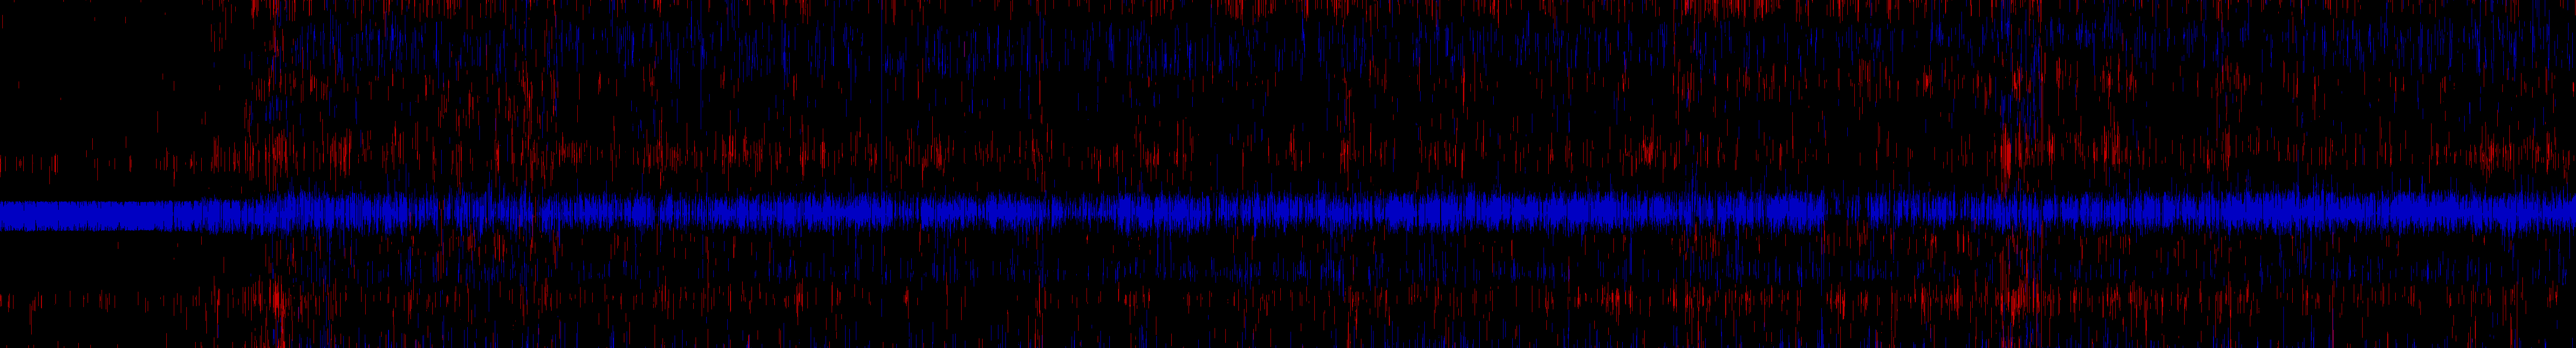

class: 6, n_cells: 1315, 23.78% of the cells
Number of CNV genes (approved by > 90% of the cells): 48
Number of CNV genes (approved by > 80% of the cells): 53


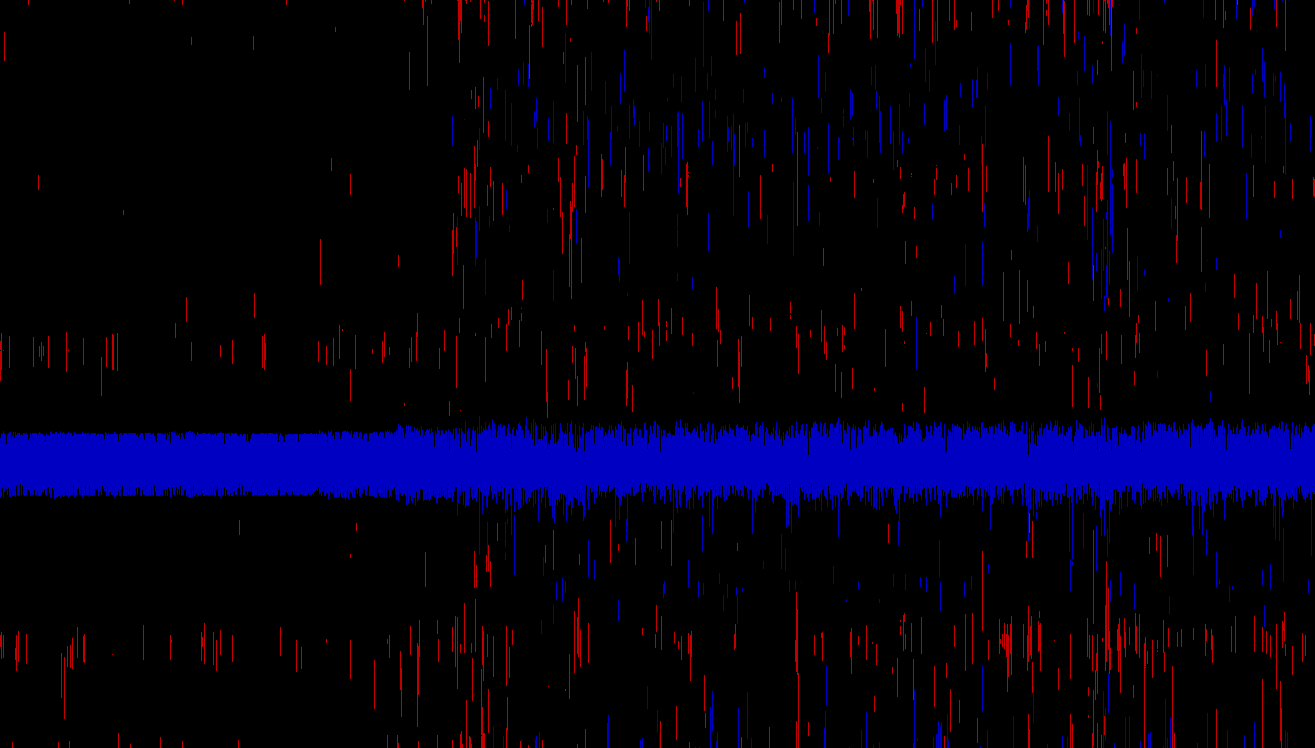

class: 3, n_cells: 1351, 24.43% of the cells
Number of CNV genes (approved by > 90% of the cells): 22
Number of CNV genes (approved by > 80% of the cells): 29


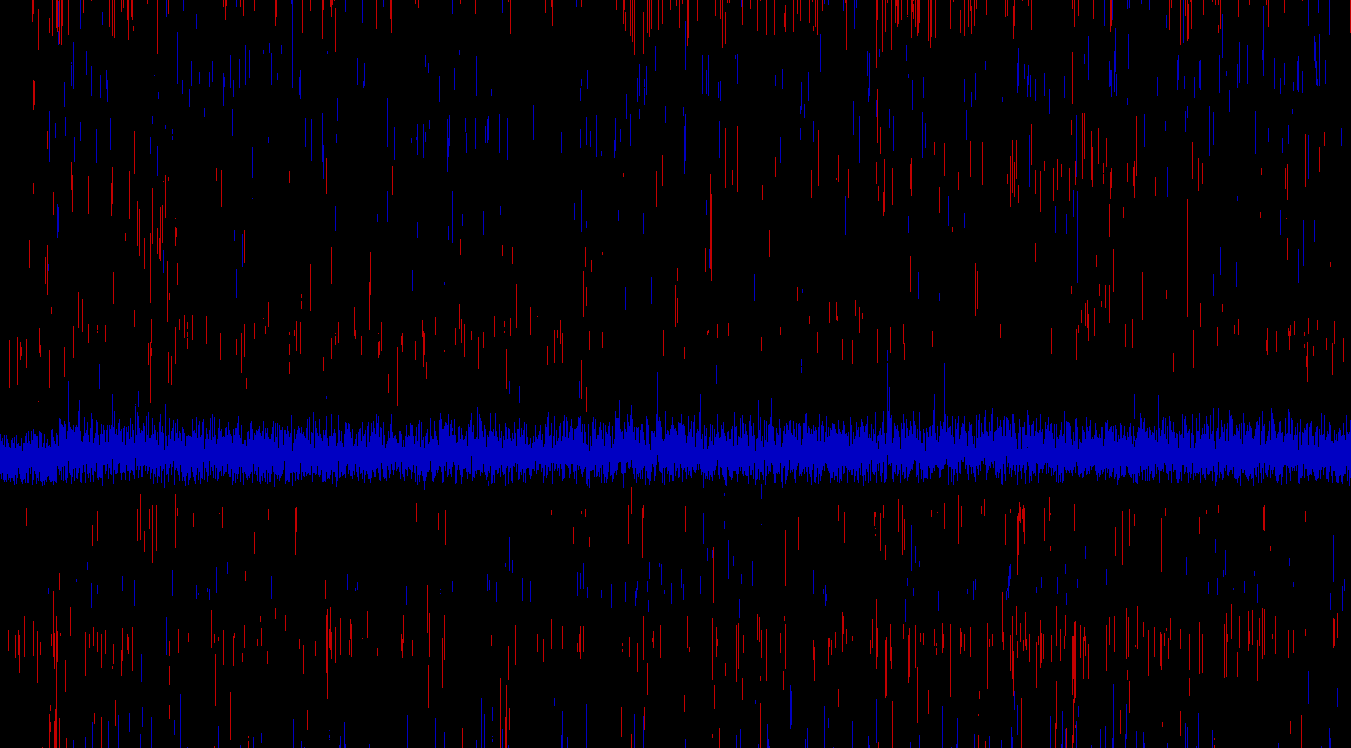

class: 1, n_cells: 830, 15.01% of the cells
Number of CNV genes (approved by > 90% of the cells): 0
Number of CNV genes (approved by > 80% of the cells): 0


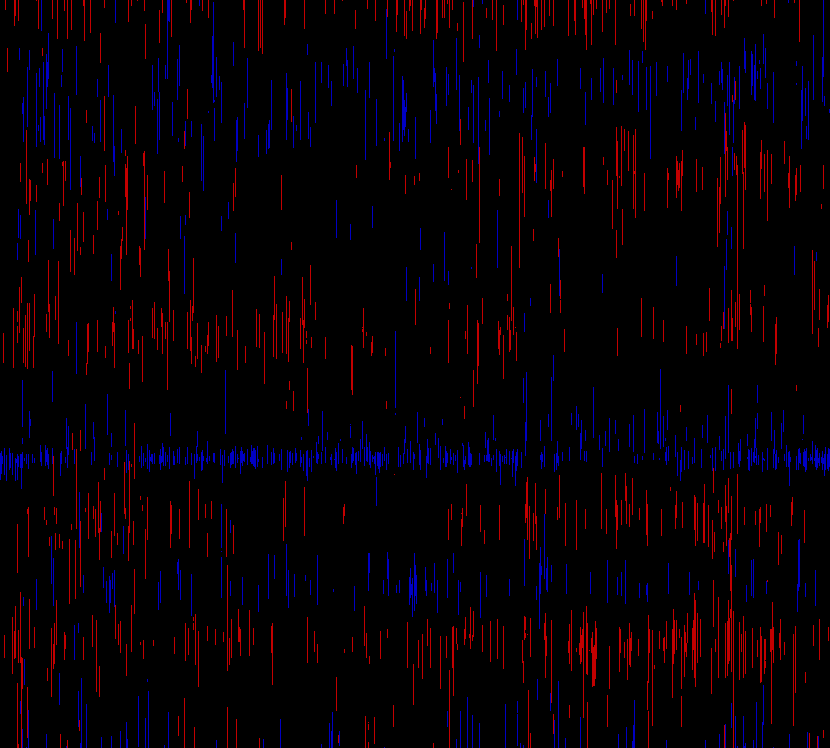

class: 2, n_cells: 385, 6.96% of the cells
Number of CNV genes (approved by > 90% of the cells): 42
Number of CNV genes (approved by > 80% of the cells): 64


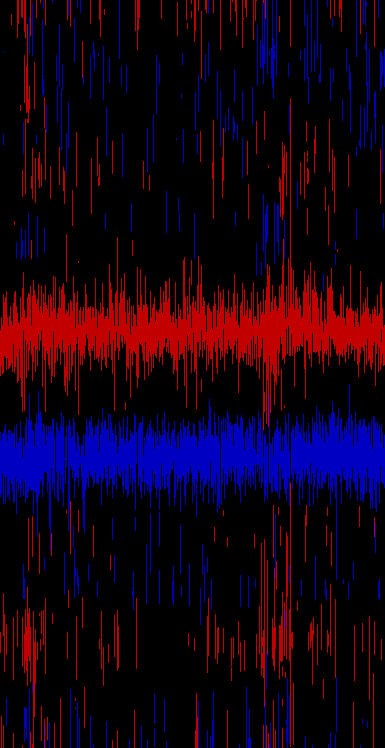

class: 4, n_cells: 1069, 19.33% of the cells
Number of CNV genes (approved by > 90% of the cells): 55
Number of CNV genes (approved by > 80% of the cells): 61


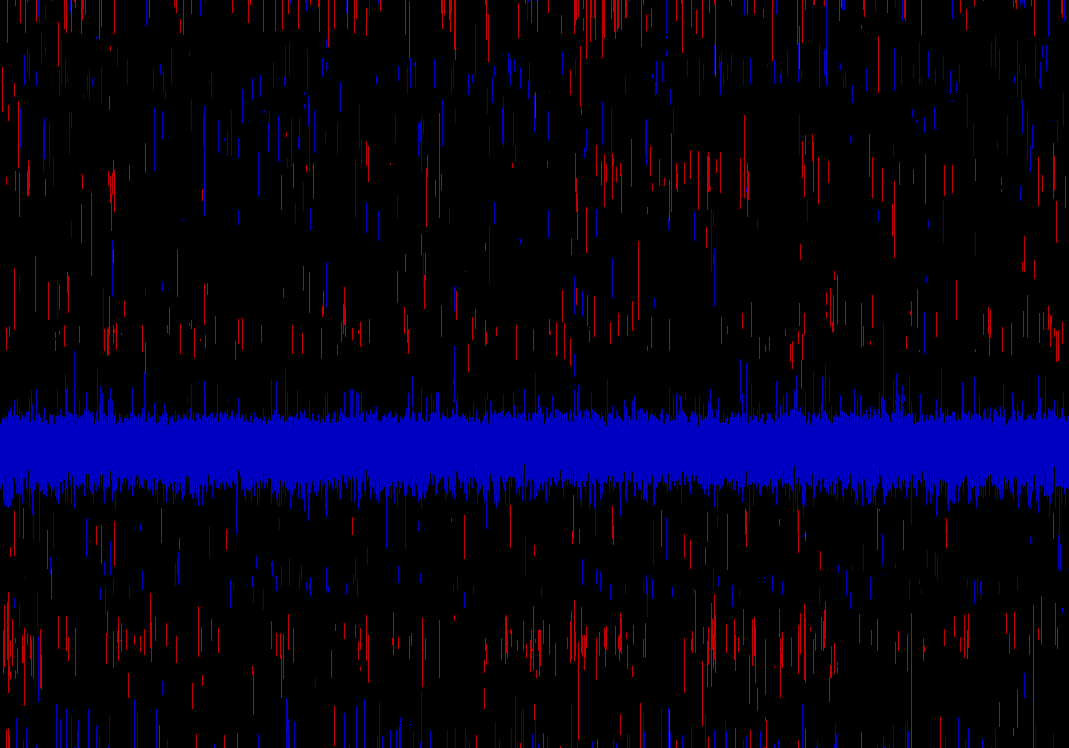

class: 0, n_cells: 299, 5.41% of the cells
Number of CNV genes (approved by > 90% of the cells): 31
Number of CNV genes (approved by > 80% of the cells): 60


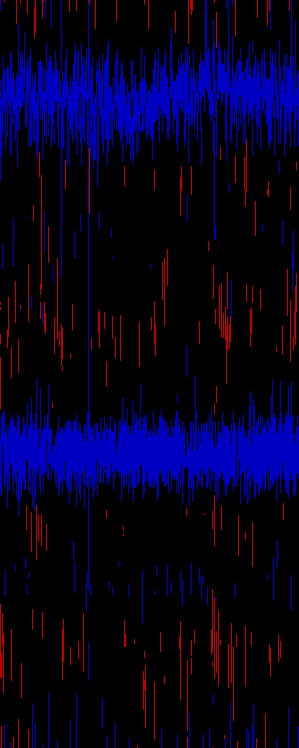

class: 5, n_cells: 280, 5.06% of the cells
Number of CNV genes (approved by > 90% of the cells): 45
Number of CNV genes (approved by > 80% of the cells): 60


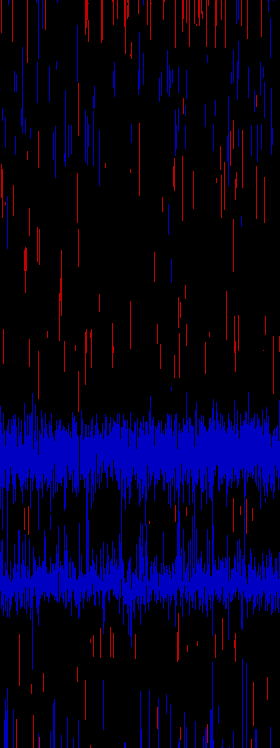

In [80]:
n_genes = chro_genes_vals.shape[0]
n_cells = chro_genes_vals.shape[1]
print(f'n_cells {n_cells}')
print(f'n_genes {n_genes}')
display(draw(chro_genes_vals))
for cls in list(dict(Counter(y_dbscan)).keys()):
    print(f'class: {cls}, n_cells: {sum(y_dbscan==cls)}, {round(sum(y_dbscan==cls)*100/n_cells, 2)}% of the cells')
    is_a_cnv_group(chro_genes_vals.T[y_dbscan==cls])
    display(draw(chro_genes_vals.T[y_dbscan==cls].T))
# display(draw(chro_genes_vals.T[y_dbscan==-1].T))

Draw all chromosome

In [107]:
split_idx = 500
remove_block = True

if not remove_block:
    for _chro_idx in range(1, 23):
        _chro_indices = retrieve_genes_indices_by_chro(_chro_idx)
        _chro_genes_vals = genes_vals[_chro_indices, :]#.sum(axis=0)
        _chro_genes_vals = (_chro_genes_vals-1)


        display(draw_split(_chro_genes_vals, split_idx))


In [109]:
len(barcodes)

5529

# DEBUG 

In [ ]:
# display(draw(chro_genes_vals.T[y_dbscan==14].T))

In [ ]:

portions = []
for chro in range(1, 23):
    print(f'Chrom num {chro}', end=' ')
    chro_indices = retrieve_genes_indices_by_chro(chro)
    chro_genes_vals = genes_vals[chro_indices, :]#.sum(axis=0)
    chro_genes_vals = (chro_genes_vals-1)

    n_gene = len(chro_indices)
    n_cells = chro_genes_vals.shape[1]
#     print(f'num of genes in chro {chro}: {n_gene}')
#     print(f'num of cells: {n_cells}')
    portion = np.sum(chro_genes_vals<-0.02)/(n_cells*n_gene)
    portions.append(portion)
    print(portion)
    
np.argsort(np.array(portions))+1
#     # insertion
#     insertion_cells = copy.deepcopy(normalized_chro_genes_vals)
#     insertion_cells[insertion_cells<0] = 0
#     #insertion_cells = np.exp(insertion_cells)
#     insertion_chro_sum = insertion_cells.sum(axis=0)

#     deletion_cells = copy.deepcopy(normalized_chro_genes_vals)
#     deletion_cells[deletion_cells>0] = 0
#     #deletion_cells = np.exp(-deletion_cells)
#     deletion_chro_sum = deletion_cells.sum(axis=0)

In [ ]:

cluster = chro_genes_vals.T[y_dbscan==1]
is_a_cnv_group(cluster)

In [207]:
chro_genes_vals.shape
# np.sum(chro_genes_vals[150, :])
np.sum(chro_genes_vals, axis=1).shape

(226,)

In [ ]:
a = chro_genes_vals.T[y_dbscan==-1][0]
b = chro_genes_vals.T[y_dbscan==-1][2]


np.linalg.norm(a-b)

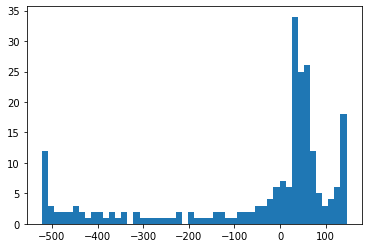

In [208]:
plt.hist(np.sum(chro_genes_vals, axis=1), bins=50)
plt.show()

In [209]:
ddd.shape

(5685, 156)

In [210]:
ddd = copy.deepcopy(deletions)
ddd[ddd!=195] = 0
ddd[ddd==195] = 1
ddd.sum(axis=1)

array([  76.,   77.,   82.,   84.,   87.,   91.,   95.,  101.,  108.,
        118.,  139.,  153.,  178.,  202.,  237.,  268.,  306.,  350.,
        391.,  444.,  506.,  595.,  679.,  758.,  877., 1005., 1136.,
       1285., 1444., 1592., 1761., 1940., 2109., 2286., 2489., 2642.,
       2795., 2929., 3030., 3127., 3226., 3308., 3369., 3435., 3518.,
       3584., 3658., 3730., 3803., 3859., 3928., 3956., 3974., 3977.,
       3984., 3986., 3981., 3968., 3964., 3947., 3930., 3902., 3874.,
       3829., 3791., 3717., 3645., 3545., 3446., 3331., 3199., 3040.,
       2881., 2701., 2521., 2317., 2104., 1921., 1724., 1550., 1371.,
       1210., 1058.,  907.,  778.,  652.,  533.,  456.,  397.,  345.,
        297.,  261.,  232.,  202.,  180.,  158.,  137.,  124.,  108.,
         85.,   78.,   69.,   61.,   55.,   50.,   41.,   36.,   34.,
         29.,   27.,   27.,   26.,   26.,   26.,   25.,   25.,   24.,
         23.,   22.,   21.,   21.,   18.,   18.,   17.,   17.,   17.,
         17.,   16.,

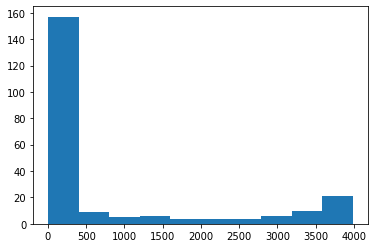

In [211]:
plt.hist(ddd.sum(axis=1))
plt.show()

In [212]:
from sklearn.manifold import TSNE
# ddd = np.concatenate([ddd.T, np.zeros((ddd.shape[0], ddd.shape[0]))])
kmeans = KMeans(n_clusters=4, random_state=0).fit(ddd)
cells_embedded = TSNE(n_components=2, random_state=21).fit_transform(ddd)

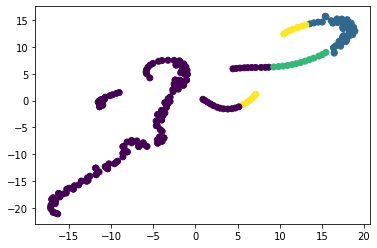

In [213]:
kmeans.labels_
colors = dict(zip(list(range(6))+[-1], [0.1, 0.2, 0.3, 0.4 ,0.5, 0.7, 0.9]))

plt.scatter(cells_embedded[:,0],cells_embedded[:,1], c = list(map(lambda x: colors[x], kmeans.labels_)))
plt.show()


In [215]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

# clf_dbscan = DBSCAN(eps = 0.2, min_samples = 10, n_jobs = -1)
# y_dbscan = clf_dbscan.fit_predict(ddd.T)

# clf_gaussian = GaussianMixture(n_components=3)
# clf_gaussian.fit(ddd.T)
# y_gaussian = clf_gaussian.predict(ddd.T)

# plt.scatter(cells_embedded[:,0],cells_embedded[:,1], c = list(map(lambda x: colors[x], y_gaussian)))
# plt.show()

In [216]:

sum(kmeans.labels_==1)

35

In [217]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(ddd)
embedding.shape

(226, 2)

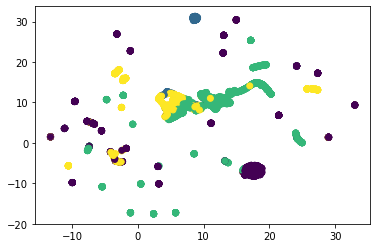

In [129]:
colors = dict(zip(list(range(6))+[-1], [0.1, 0.2, 0.3, 0.4 ,0.5, 0.7, 0.9]))


# clf_dbscan = DBSCAN(eps = 0.2, min_samples = 10, n_jobs = -1)
# y_dbscan = clf_dbscan.fit_predict(ddd.T)

clf_gaussian = GaussianMixture(n_components=4)
clf_gaussian.fit(ddd)
y_gaussian = clf_gaussian.predict(ddd)


plt.scatter(embedding[:, 0],embedding[:, 1], c = list(map(lambda x: colors[x], y_gaussian)))
plt.show()


In [135]:
sum(y_gaussian==1)

310

In [137]:
clf_dbscan = DBSCAN(eps = 0.2, min_samples = 10, n_jobs = -1)
y_dbscan = clf_dbscan.fit_predict(ddd)

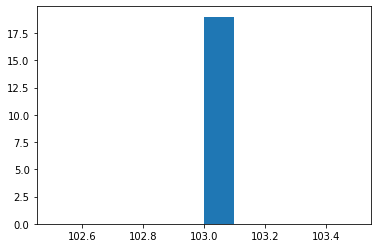

In [192]:
from collections import Counter
Counter(y_dbscan)
# y_dbscan[-156:]


plt.hist(np.sum(ddd[y_dbscan==19], axis=1))
plt.show()

In [194]:
np.where(kmeans.labels_==1)

(array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
          11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
          22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
          33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
          44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
          55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
          66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
          77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
          88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,
          99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,
         110,  111,  112,  113,  114,  115,  116,  117,  118,  119,  120,
         121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
         132,  133,  134,  135,  136,  137,  138,  139,  140,  141,  142,
         143,  144,  145,  146,  147, 

In [218]:
kkk = ddd[kmeans.labels_==1]
rgbArray = np.zeros((n_gene, kkk.shape[0], 3), 'uint8')
rgbArray[..., 0] = 0
rgbArray[..., 1] = 0 #chro_genes_vals*256
rgbArray[..., 2] = kkk.T*195 #chro_genes_vals*256
img = Image.fromarray(rgbArray)
img

ValueError: could not broadcast input array from shape (5529,35) into shape (226,35)

Creating a dictionary containing all invercnv.png of all samples:

In [496]:
from shutil import copyfile


DIR_PATH = r'D:\Technion studies\Keren Laboratory\python_playground\outputs\inferCNV\executions\all_data_31.12.20'
OUT = r'D:\Technion studies\Keren Laboratory\python_playground\outputs\temporal garbage\ddd'
for file, dst in [(join(DIR_PATH, folder, 'infercnv.png'), join(OUT, f'{folder}_infercnv.png')) for folder in os.listdir(DIR_PATH)]:
    if os.path.isfile(file):
        copyfile(file, dst)
